# Nonlinear regression

Linear regression limits the representation of the dataset to a function of the form

$$
f(\bfx) = \bfx^T \bfw. 
$$

This is a **linear** function, meaning that two key properties are satisfied. For all possible vectors $\bfu,\bfv$ and numbers $c$,

1. $f(\bfu+\bfv) = f(\bfu) + f(\bfv)$,
2. $f(c\bfu) = c f(\bfu)$.

These properties are the essence of what makes a function "easy" to manipulate, solve for, and analyze. For our particular $f$, they follow easily from how the dot product is defined. For example,

$$
f(c\bfu) = (c\bfu)^T\bfw = \sum_{i=1}^d (cu_i) w_i = c \sum_{i=1}^d u_i w_i = c(\bfu^T\bfw) = c f(\bfu). 
$$

One benefit of the linear approach is that the dependence of the weight vector $\bfw$ on the regressed data is also linear, which makes solving for it relatively straightforward. 

Linear relationships are an approach in keeping with Occam's Razor: as the simplest type of multidimensional function, they should be our first resort. However, not all datasets are well-represented by a linear function of the features. We already saw one way to go beyond linear relationships: the addition of polynomial features. Interpreted correctly, this technique leads to the kernel trick we saw employed for the support vector classifier. Entirely different types of nonlinear regression result from reconsidering our other classification algorithms.

## Nearest neighbors

To use kNN for regression, we can find the $k$ nearest examples as with classification, but replace voting on classes with the mean or median of the neighboring values. A simple thought experiment confirms that the resulting approximation is not linear.

::::{prf:example}
:label: example-nonlinear-knn
If we regress the one-dimensional dataset $(0,0)$, $(2,1)$ using kNN with $k=1$, then the resulting approximation $f(x)$ is

$$
f(x) = \begin{cases}   0, & x < 1, \\ \tfrac{1}{2}, & x=1, \\  1, & x > 1. \end{cases}
$$

(Convince yourself that the result is the same whether the mean or the median is used.) So, for instance, $f(1.2)=1$, while $2f(0.6) = 0$, not $f(2 \cdot 0.6)$.
::::

kNN regression can produce a function that conforms itself to the training data much more closely than a linear regressor does, which can both decrease bias and increase variance, especially for small values of $k$. As illustrated in the following video, increasing $k$ flattens out the approximation, decreasing variance while increasing bias.

```{raw} html
<video width=640 controls src="../_static/knn_regression.mp4"></video>
```

As with the classification variant, we can choose the norm to use, and whether to weight the neighbors equally or by inverse distance. Also, it is once again recommended to start with z-scores for the features rather than raw data; it is not helpful, however, to standardize the target values being regressed.


## Decision tree

Recall that a decision tree recursively divides the examples into subsets. As with kNN, we can replace taking a vote over a leaf subset with taking a mean or median. However, the splits used in a decision tree depend on the data as well.

Instead of using a measure of class impurity to determine the best split, the split is chosen to cause the greatest reduction in dispersion within the two subsets. The most obvious candidates for measuring dispersion are standard deviation, which is appropriate if we use the mean of the values in a leaf, and the mean absolute deviation (MAD), which is typical when the median is used. If $t_1,\ldots,t_m$ are elements of any set, then their MAD is given by

$$
\text{MAD} = \frac{1}{m} \sum_{i=1}^m | t_i - t_\text{med} |,
$$

where $t_\text{med}$ is the median value. As with classification, a proposal to split into subsets $S$ and $T$ is assigned the weighted score

$$
Q = |S| H(S) + |T| H(T),
$$

where $H$ is the chosen dispersion measure over subsets.

::::{prf:example}
:label: example-other-dtree
Choose the best split using the MAD criterion for the observations $x_i=i$, $i=1,\ldots,4$, where $y_1=2$, $y_2=-1$, $y_3=1$, $y_4=0$.

:::{dropdown} Solution
The original set has median $\frac{1}{2}$ and gets a weighted dispersion of $\frac{5}{2}(3+3+1+1)=20$. There are three ways to split the data, depending on where the partition falls in relation to the $x_i$.

* $S=\{2\},T=\{-1,1,0\}$: 

$$ Q &= 1\left[ \frac{1}{1}\left( |2-2| \right)  \right] +  3 \left[ \frac{1}{3}\left( | -1-0 | + |1-0| + |0-0|  \right)  \right]\\ &=  0 + 2 = 2.$$

* $S=\{2,-1\},T=\{1,0\}$: 

$$ Q &= 2\left[ \frac{1}{2}\left( \left| 2-\tfrac{1}{2} \right| + \left| -1-\tfrac{1}{2} \right| \right)  \right] +  2 \left[ \frac{1}{2}\left( \left|1-\tfrac{1}{2} \right| + \left|0-\tfrac{1}{2} \right|  \right)  \right]\\ 
&=  3 + 1 = 4.$$

* $S=\{2,-1,1\},T=\{0\}$: 

$$ Q &= 3\left[ \frac{1}{3}\left( \left| 2-1 \right| + \left| -1-1 \right|+ |1-1| \right)  \right] +  1 \left[ \frac{1}{1}\left(  \left|0-0 \right|  \right)  \right]\\ 
&=  3 + 0 = 3.$$

Thus, the first split above produces the smallest total dispersion.
:::
::::

To predict a value for a query $x$, we follow the tree until ending at a leaf, where we use the mean (if dispersion is STD) or median (if dispersion is MAD) of the examples in the leaf.

Here is a simple example based on two dimensions.

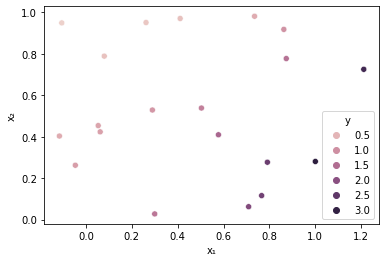

In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

rng = default_rng(1)
x1 = rng.random((10,2))
x1[:,0] -= 0.25
x2 = rng.random((10,2))
x2[:,0] += 0.25
X = np.vstack((x1,x2))
y = np.exp(X[:,0]-2*X[:,1]**2+X[:,0]*X[:,1])

import seaborn as sns
df = pd.DataFrame({"x₁":X[:,0],"x₂":X[:,1],"y":y})
sns.scatterplot(data=df,x="x₁",y="x₂",hue="y");

Here is a shallow tree for regression on this data. The default choice is to use STD as the dispersion measure (called `squared_error` in sklearn).

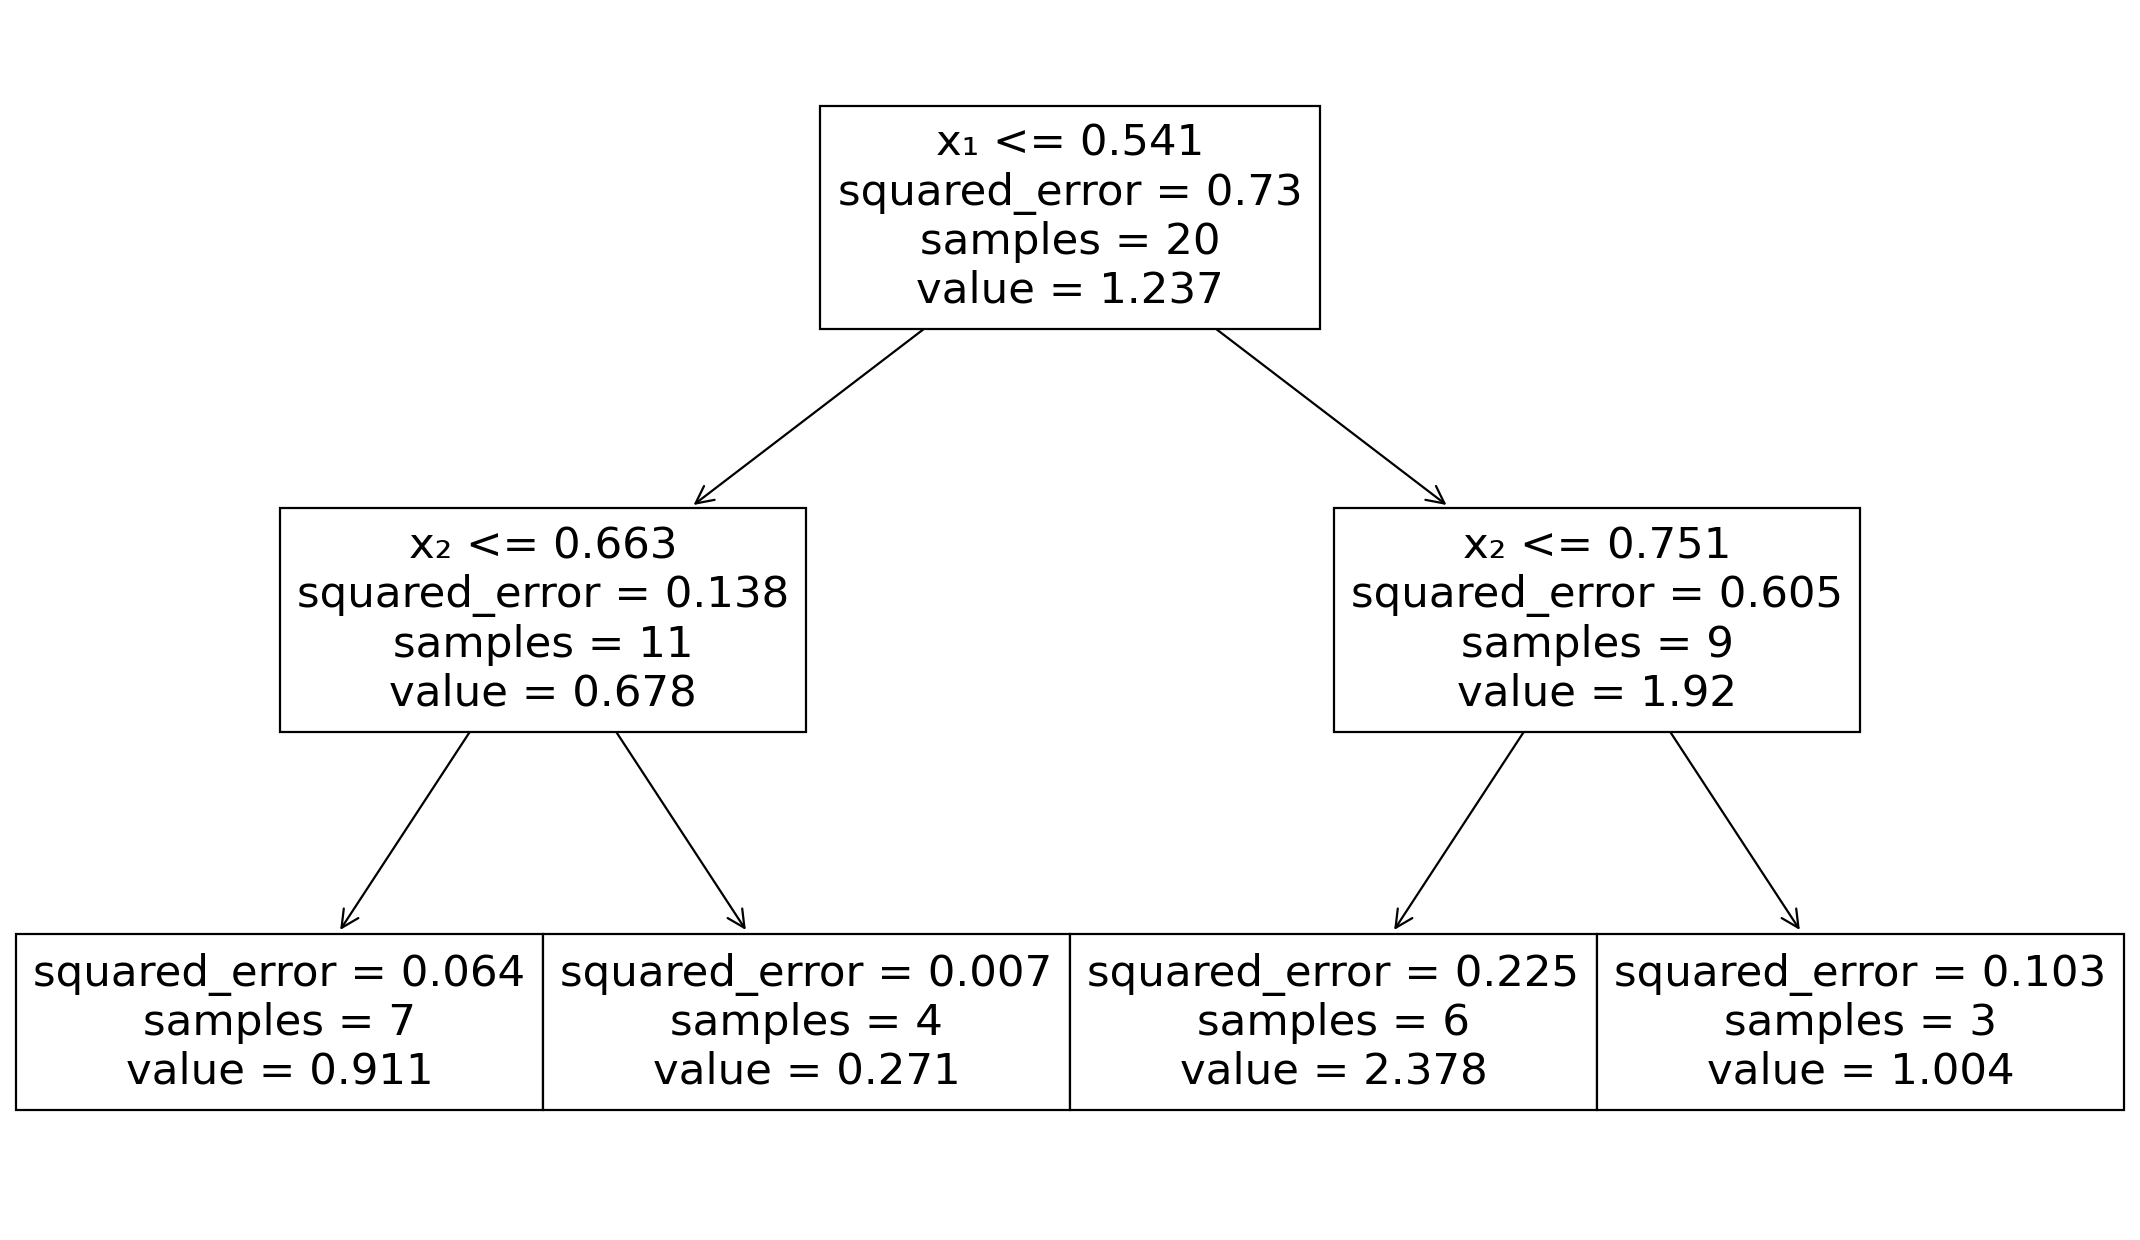

In [2]:
from sklearn.tree import DecisionTreeRegressor,plot_tree
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(X,y)

from matplotlib.pyplot import figure
figure(figsize=(17,10),dpi=160)
plot_tree(dt,feature_names=["x₁","x₂"]);

All of the original samples end up in one of the four leaves. We can find out which goes where using `apply`:

In [3]:
leaf = dt.apply(X)
print(leaf)

[3 3 2 5 2 2 3 2 2 2 5 6 5 5 3 5 6 6 2 5]


With some pandas grouping, we can find out the mean value for the samples within each leaf:

In [4]:
leaves = pd.DataFrame(zip(y,leaf),columns=["y","leaf"])
leaves.groupby("leaf")["y"].mean()

leaf
2    0.911328
3    0.270725
5    2.378427
6    1.003786
Name: y, dtype: float64

All values of the regressor will be one of the four values above. This is exactly what is done internally by the `predict` method of the regressor:

In [5]:
print(dt.predict(X))

[0.27072468 0.27072468 0.91132782 2.37842709 0.91132782 0.91132782
 0.27072468 0.91132782 0.91132782 0.91132782 2.37842709 1.00378567
 2.37842709 2.37842709 0.27072468 2.37842709 1.00378567 1.00378567
 0.91132782 2.37842709]


## Case study

Here again is the dataset of cars and their fuel efficiency (measured as MPG). A linear regression on four quantitative features is only OK.

In [6]:
cars = sns.load_dataset("mpg").dropna()
X = cars[["displacement","horsepower","weight","acceleration"]]
y = cars["mpg"]

from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,random_state=0)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_tr,y_tr)
print("linear model CofD score:",lm.score(X_te,y_te))

linear model CofD score: 0.6927894782580892


One consequence of linearity is that using standard scores should make no difference. (However, if the original fit fails due to poor conditioning, it may produce more accurate results.)

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
lm_std = pipe = make_pipeline(StandardScaler(),LinearRegression())
lm_std.fit(X_tr,y_tr)
print("linear model with standardization, CofD score:",lm.score(X_te,y_te))

linear model with standardization, CofD score: 0.6927894782580892


While we could try adding polynomial features to improve the linear regressor, there are a lot of potential interaction terms to be added. Instead, we try a kNN regressor, doing a simple grid search to find good hyperparameters.

In [8]:
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.neighbors import KNeighborsRegressor

kf = KFold(n_splits=6,shuffle=True,random_state=1)
grid = {"n_neighbors":range(2,25),
        "weights":["uniform","distance"] }
knn = GridSearchCV(KNeighborsRegressor(),grid,cv=kf)
knn.fit(X_tr,y_tr)

print("best kNN CofD score:",knn.score(X_te,y_te))

best kNN CofD score: 0.6925833004606998


No improvement was made. But unlike the linear regressor, kNN regression is sensitive to feature scaling and should be used with standardization.

In [9]:
pipe = make_pipeline(StandardScaler(),KNeighborsRegressor())
grid = {"kneighborsregressor__n_neighbors":range(2,25),
        "kneighborsregressor__weights":["uniform","distance"] }
knn_std = GridSearchCV(pipe,grid,cv=kf)
knn_std.fit(X_tr,y_tr)

print("best kNN with standardization, CofD score:",knn_std.score(X_te,y_te))

best kNN with standardization, CofD score: 0.7438913789127495


As you can see above, we got a fairly substantial improvement over the linear regressor.

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_paosbau2&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_lw9utfja" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>